In [47]:
# SPDX-FileCopyrightText: 2022 Aleksander Grochowicz
#
# SPDX-License-Identifier: GPL-3.0-or-later
import copy
from itertools import product

import scipy as sp
import numpy as np
import pandas as pd


from datetime import date
import holidays
from regression_utilities import compute_correlation, compute_rmse, load_regression, compute_cdd_hdd, daily_regression, create_daily_data, create_hourly_data

import atlite
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import mpl_toolkits.mplot3d as a3
from matplotlib.ticker import FixedLocator, FixedFormatter
mpl.rcParams['figure.dpi'] = 150
import seaborn as sns

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
from scipy.stats import (gamma, expon)

from utilities import (seasonal_pattern, estimate_partialacf, create_ar_model, estimate_variance)

import gurobipy as gp
from gurobipy import GRB

from multiprocessing import Pool



In [2]:
# Use the pgf backend for pdf exports (allows us to use xelatex).
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)

# Set up font.
plt.rcParams.update({
    "axes.formatter.limits": [-3,3], # Use scientific notation for large numbers.
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.texsystem": "lualatex",
    "pgf.preamble": "\n".join([
         r"\usepackage{unicode-math}",
         r"\setmainfont{TeX Gyre Termes}",
         r"\setmathfont{TeX Gyre Termes Math}",
    ])
})

cm = 1/2.54  # centimeters in inches

In [3]:
sample_length = 100 # number of years to be generated, both for demand and production.
save_files = True # if True, save all values that are being generated

In [4]:
cs = {
    "yellow": "#faecbe",
    "rose": "#f7cacd",
    "purple": "#d6b0d6",
    "burgundy": "#8a5066",
    "pink": "#8a5066",
    "blue": "#5c8bc4"
}

# Generate demand data

This approach follows [the approach from this github repository](https://github.com/aleks-g/multidecade-data). We also use the workflow from there.
We use historical load from Nordpool and temperature data for 2013 until 2018 (on market zone level, hourly) and aggregate it to northern and souther Norway to identify the relationship between load and temperature.
After a regression to find base load, we simulate temperatures in northern and southern Norway based on an AR(3) model (trained on ERA5 data from 1990 until 2020) such that we can obtain arbitrary many years of temperature data.
We can plug these data in and the heating degree days determine the temperature-dependent load in both regions.
With this we can generate arbitrary many years of demand data.

Note that Nordpool data is now behind a paywall and cannot be shared., but we downloaded it when it was still freely available. There is open ENTSO-E data on market zone level for Norway, but it seems to be flawed and have inexplicabe trends in each month (that do not exist in the Nordpool data).

### Fetch temperature data from ERA5

In [5]:
# # Fetch temperature data for the market zones
# years = range(1991,2021)
# cutouts = {}
# for y in years:
#     cutouts[y]= atlite.Cutout(path="../../research/modelling/new-cutouts/europe-era5_" + str(y) +".nc",
#     module="era5",
#     x = slice(4,32),
#     y=slice(57,72),
#     time=str(y)
#     )
#     cutouts[y].prepare()

# # Pick shape file to aggregate the grid cell data.
# norway = gpd.read_file('data/shapefiles/marketzones_4326.geojson')
# norway = norway.set_index('ElSpotOmr')

# # Aggregate temperatures to market zones
# temp = {} #create dictionary for each year
# for j in cutouts.keys():
#     temperatures = cutouts[j].temperature(shapes = norway, per_unit = True) #Converts temperatures from Kelvin to Celsius and also aggregates it to shapes of chosen region.
#     temp[j] = temperatures

# zones = list(norway.index)
# temp_data = xr.concat([temp[j] for j in temp.keys()], dim="time")
# temps = temp_data.to_pandas()

In [6]:
# # Aggregate the temperatures to the regions
# south_area = sum(norway.loc[i, "Shape_Area"] for i in ["NO 1", "NO 2", "NO 5"])
# north_area = sum(norway.loc[i, "Shape_Area"] for i in ["NO 3", "NO 4"])
# south_shares = {}
# north_shares = {}
# for i in ["NO 1", "NO 2", "NO 5"]:
#     south_shares[i] = round(norway.loc[i, "Shape_Area"]/south_area,3)
# for i in ["NO 3", "NO 4"]:
#     north_shares[i] = round(norway.loc[i, "Shape_Area"]/north_area,3)

# data = pd.DataFrame(index = temps.index)
# data["NO-N"] = sum(temps[i] * north_shares[i] for i in ["NO 3", "NO 4"])
# data["NO-S"] = sum(temps[i] * south_shares[i] for i in ["NO 1", "NO 2", "NO 5"])
# data = data.round(2)

# if save_files:
#     data.to_csv("./data/weather-input/ERA5_temperatures_1991-2020_norway_regions.csv")

# # For later reference.
# temperature_data = data.copy()

In [7]:
temperature_data = pd.read_csv("./data/weather-input/ERA5_temperatures_1991-2020_norway_regions.csv", index_col=0, parse_dates=True)

## Regression for temperature-dependent load

### Input
- Load data for the market zones NO1 - NO5 from Nordpool on an hourly basis (2013 - 2019, the last year for validation). We remove COVID years.
- Temperature data for the regions NO-N (NO3 + NO4) and NO-S (NO1 + NO2 + NO5) from ERA5 on an hourly basis (2013 - 2019).

In [8]:
# Choose years to use for training and test data.
startyear = 2014
endyear = 2018 + 1  # 2010-2014 inclusive.
val_year = 2019
years = list(range(startyear, endyear))
nb_y = len(years)

In [9]:
# Prepare demand data for regression.
# Import load data for the market zones.
demand_input = pd.read_csv('./data/demand-input/Consumption_NO_market-zones_2013-2021_hourly_MWh.tsv', sep = '\t', index_col = 0, parse_dates=True)
demand_input = round(demand_input, 0)
demand_input.index = pd.to_datetime(demand_input.index,utc=True)
demand_input = demand_input.tz_localize(None)
demand_input = demand_input.loc[:"2020"]

zones = ["NO1", "NO2", "NO3", "NO4", "NO5"]
regions = ["NO-N", "NO-S"]

# Test data
demand_val = copy.deepcopy(demand_input)
demand_val = demand_val[zones]
demand_val = demand_val.loc[str(val_year)]


# Training data: demand
demand = copy.deepcopy(demand_input)
demand = demand[zones]
demand = demand.loc[str(startyear):str(endyear-1)]


def add_zones_to_regions(dem, regions):
    dem["NO-N"] = dem["NO3"] + dem["NO4"]
    dem["NO-S"] = dem["NO1"] + dem["NO2"] + dem["NO5"]
    dem_output = dem[regions]
    return dem_output

demand = add_zones_to_regions(demand, regions)
demand_val = add_zones_to_regions(demand_val, regions)

if save_files:
    demand.to_csv(f"data/processing/demand_nordpool_regions_{startyear}-{endyear-1}.csv")


In [10]:
# Prepare temperature data, weekdays and look for missing data.
# Load temperature data
t = copy.deepcopy(temperature_data)
t_val = copy.deepcopy(temperature_data)

# Extract temperature data for the training period
temp = {} #create dictionary for each region
for j in t.columns:
    temp[j] = t[j]
    temp[j].index = pd.to_datetime(temp[j].index)
    temp[j] = temp[j].loc[str(startyear):str(endyear-1)]

t_val = t_val.loc[str(val_year)]

# Check for missing data
# Create dictionary with demand time series for all regions
d = {}
for i in regions:
    d["{0}".format(i)] = pd.DataFrame(demand[i].loc[str(startyear):str(endyear - 1)].copy())

# Determine day of the week  
for i in d.keys():
    d[i] = pd.DataFrame(d[i])
    d[i]['weekday'] = d[i].index.to_series().dt.dayofweek
    d[i].columns = ['demand', 'weekday']

# For chosen regions check for periods of NaN values: https://stackoverflow.com/questions/66426653/count-contiguous-nan-values-and-get-the-start-and-final-date-of-the-nan-contiguo
# This should show missing values in all years, including the validation year.
for c in regions:
    s = demand.index.to_series()
    m2 = demand[c].isna() #creates masks with difference between days is a day, and where the country's demand contains NaN values
    out = s[m2].groupby((~m2).cumsum())\
        .agg(['first', 'last', 'count']).reset_index(drop=True) #aggregate length of periods of missing values first and then group them by the first and last daye as well as the length.
    print('Missing values for',c)
    print(out)

# Dictionary with demand data frames for each country
d_val = {}
for i in regions:
    d_val[i] = pd.DataFrame(demand_val[i].loc[str(val_year)].copy())

# Determine day of the week
for i in d.keys():
    d_val[i] = pd.DataFrame(d_val[i])
    d_val[i] = d_val[i].fillna(method = 'bfill')
    d_val[i]['weekday'] = d_val[i].index.to_series().dt.dayofweek
    d_val[i].columns = ['demand', 'weekday']

# Dictionary with temperature for each country 
temp_val = {} #create dictionary for each country
for j in regions:
    temp_val[j] = t_val[j]
    temp_val[j].index = pd.to_datetime(temp_val[j].index)


Missing values for NO-N
Empty DataFrame
Columns: [first, last, count]
Index: []
Missing values for NO-S
Empty DataFrame
Columns: [first, last, count]
Index: []


In [11]:
# Prepare holidays.
list_holidays = {}
yrs = years.copy()
for c in regions:
    list_holidays[c] = holidays.CountryHoliday("NO", years = list(range(2013,2020)))

# Add last week of the year as holidays.
for y in list(range(2013, 2020)):
    for i in regions:
        # Add the days between Christmas Eve and New Year's Eve as holidays.
        list_holidays[i].append(date(y,1,2))
        list_holidays[i].append(list(pd.date_range(start = date(y, 12, 24), end = date(y, 12, 31), freq = '1D')))
     

### Determine base and temperature-dependent laod

In [12]:
# Resample to daily data and add holidays.
# Create data frames for each country to prepare regression 
dt = {}
for i in regions:
    dt[i] = pd.DataFrame(d[i].loc[str(startyear):str(endyear - 1)])
    dt[i].fillna(method = 'bfill')
    dt[i]['temp'] = temp[i].values
    dt[i]['weekday'] = d[i]['weekday']
    dt[i]['holiday'] = False

# Add holidays
dt_with_holidays = dt.copy()
for i in dt_with_holidays.keys():
    for j in dt_with_holidays[i].index:
        if j in list_holidays[i]:
            dt_with_holidays[i].at[j, 'holiday'] = True

# Same for validation year (use the same holidays)
dt_val = {}
for i in regions:
    dt_val[i] = pd.DataFrame(d_val[i].loc[str(val_year)])
    dt_val[i].fillna(method = 'bfill')
    dt_val[i]['temp'] = temp_val[i].values
    dt_val[i]['weekday'] = d_val[i]['weekday']
    dt_val[i]['holiday'] = False

dt_with_holidays_val = dt_val.copy()
for i in dt_with_holidays_val.keys():
    for j in dt_with_holidays_val[i].index:
        if j in list_holidays[i]:
            dt_with_holidays_val[i].at[j, 'holiday'] = True

# Add weekly profiles
data_daily_values = dt.copy()
for i in dt.keys():
    data_daily_values[i] = data_daily_values[i].resample('1D').mean()

In [13]:
# Consider heating and cooling degree days
daily_hc = compute_cdd_hdd(data_daily_values, regions, threshold_hdd = 15.5, threshold_cdd = 15.5)
# Do the same for validation
data_daily_values_val = {}
for i in regions:
    data_daily_values_val[i] = dt_val[i].resample('1D').mean()

daily_hc_val = compute_cdd_hdd(data_daily_values_val, regions, threshold_hdd = 15.5, threshold_cdd = 15.5)


In [14]:
# Regression on temperature
par_hc_l, temp_hc_l, aic_hc_l, trend_hc_l, fourier_hc_l = daily_regression(place=regions,dict = dt, weekly_regression = daily_hc, daily = False, trend = 0, fourier_component = 0)

NO-N 8 has p-value 0.04832038905502859 therefore we consider it statistically insignificant and set the parameter to 0


In [15]:
# Create artificial daily data
artificial_data, days, first_day = create_daily_data(par_hc_l, trend_hc_l, daily_hc, temp_hc_l, regions, start = startyear, end = endyear, validation_days = 0)

if save_files:
    par_hc_l.to_csv(f"data/processing/reg_norway_parameters_days_of_week_{startyear}-{endyear-1}.csv")
    trend_hc_l.T.to_csv(f'data/processing/reg_norway_parameters_trend_{startyear}-{endyear-1}.csv')
    temp_hc_l.T.to_csv(f'data/processing/reg_norway_parameters_temp_{startyear}-{endyear-1}.csv')

## Generate temperature data

### Generate synthetic temperature data

In [16]:
# Load temperature data.
regions = ["NO-N", "NO-S"]
temperatures = copy.deepcopy(temperature_data)
temperatures.index = pd.DatetimeIndex(temperatures.index)

temperatures = temperatures.resample("1D").mean()
temperatures = temperatures.loc[~temperatures.index.astype(str).str.contains('02-29')] # Remove leap days
temperatures = temperatures.reset_index()[regions]

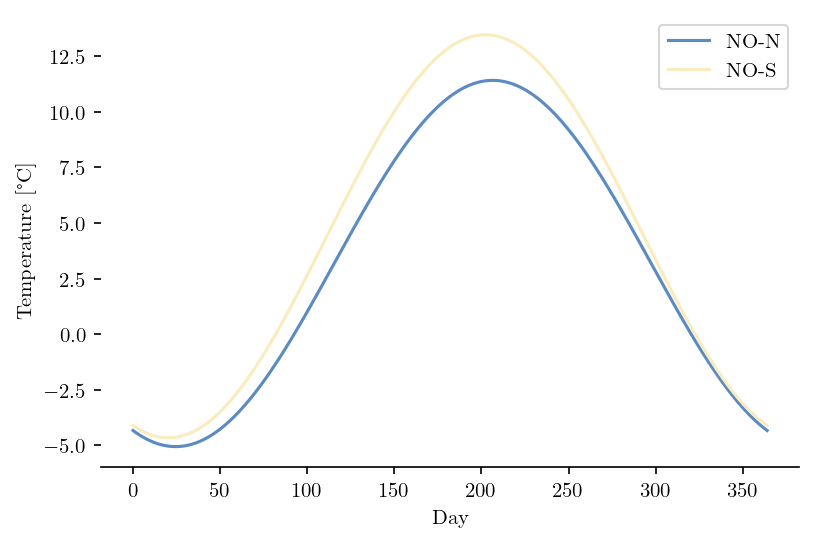

In [17]:
# Deseasonalise data.
seasonality, deseasonalised = seasonal_pattern(temperatures, 365, plot=False)
seasonality.plot( color = [cs["blue"], cs["yellow"]]);
plt.ylabel("Temperature [°C]");
plt.xlabel("Day");
for loc in ["right", "top", "left"]:
    plt.gca().spines[loc].set_visible(False)

Now have deseasonalised data:
`deseasonalised` = `temperature` - `S_n`

$ X(t) = T(t) - S(t) = T(t) - (a + b \cdot \sin(2 \pi t / 365) + c \cdot \cos(2 \pi t / 365)) $

In [18]:
from statsmodels.tsa.stattools import pacf as PACF
def estimate_partialacf(data: pd.DataFrame):
    """Compute and plot partial ACF. Note that we should use deseasonalised data here."""
    pacf = {}
    for c in data.columns:
        pacf[c] = PACF(data[c])

    fig, ax = plt.subplots()
    pd.DataFrame.from_dict(pacf)[:10].plot(kind="bar", ax=ax, color = [cs["blue"], cs["yellow"]])
    for v in [0, 0.2, -0.2]:
        ax.hlines(v, 0, 10, color="grey", ls=":")
    plt.show()

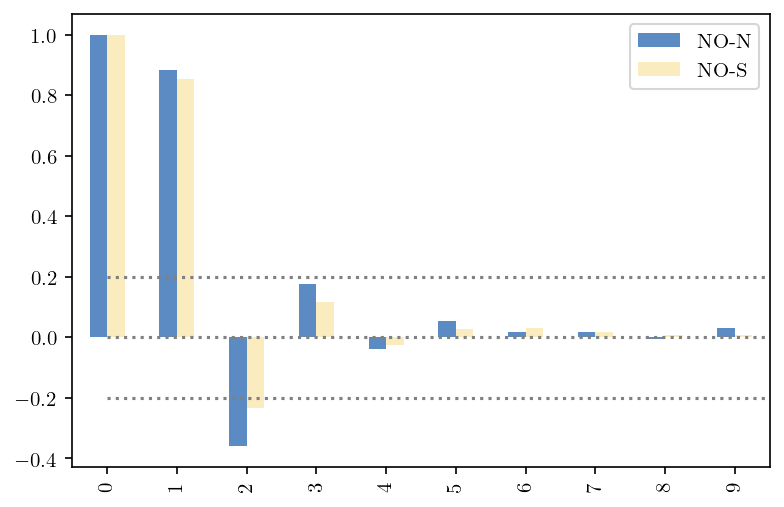

In [19]:
# Now want to remove the lags, for this choose an AR model.
estimate_partialacf(deseasonalised)

# It seems like the AIC/BIC is improved if we include 3 lags, but it's not that large a difference. We probably shouldn't go past `3` lags, maybe just `2`.



NO-N 36702.586891655934
NO-S 42214.192606581455


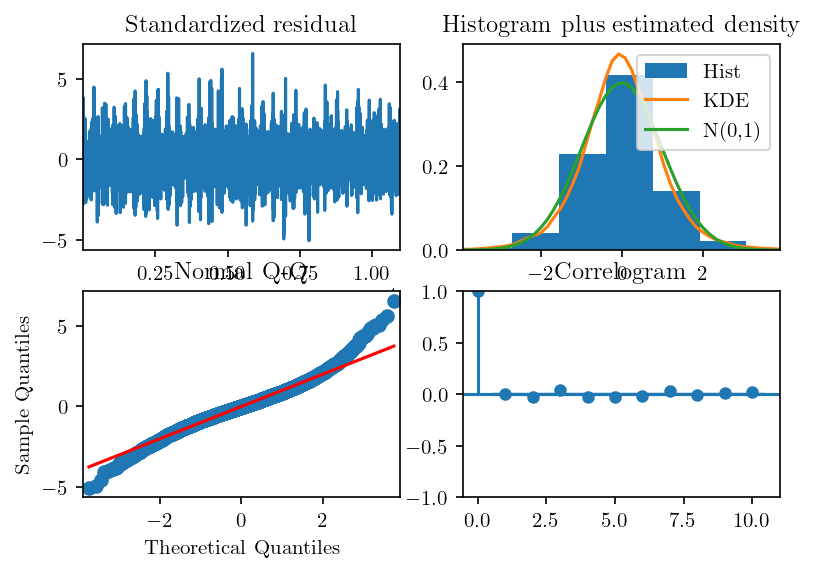

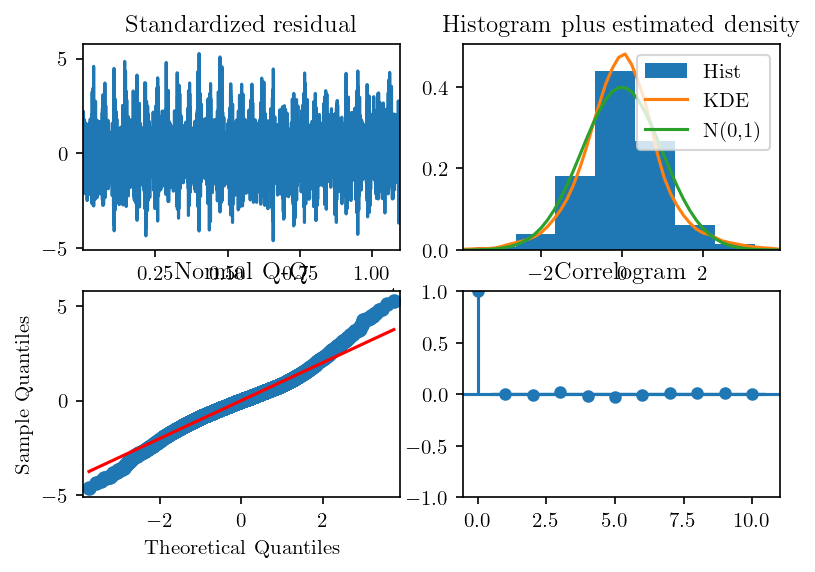

In [20]:
# Fit AR model.
ar_params, residual = create_ar_model(deseasonalised, 3)

In [21]:
# Observe heteroskedasticity. However, finding a seasonality function is not necessarily better. In fact we therefore do not add it to the model.
# variance_seasonal,variability = estimate_variance(residual, 365)

# fig, ax = plt.subplots()
# (residual/residual.std()).plot.density(ax=ax)
# ax.plot(np.arange(-5, 5, 0.001), sp.stats.norm.pdf(np.arange(-5, 5, 0.001),0,1))
# ax.set_xlim(-5,5)

Constant volatility.

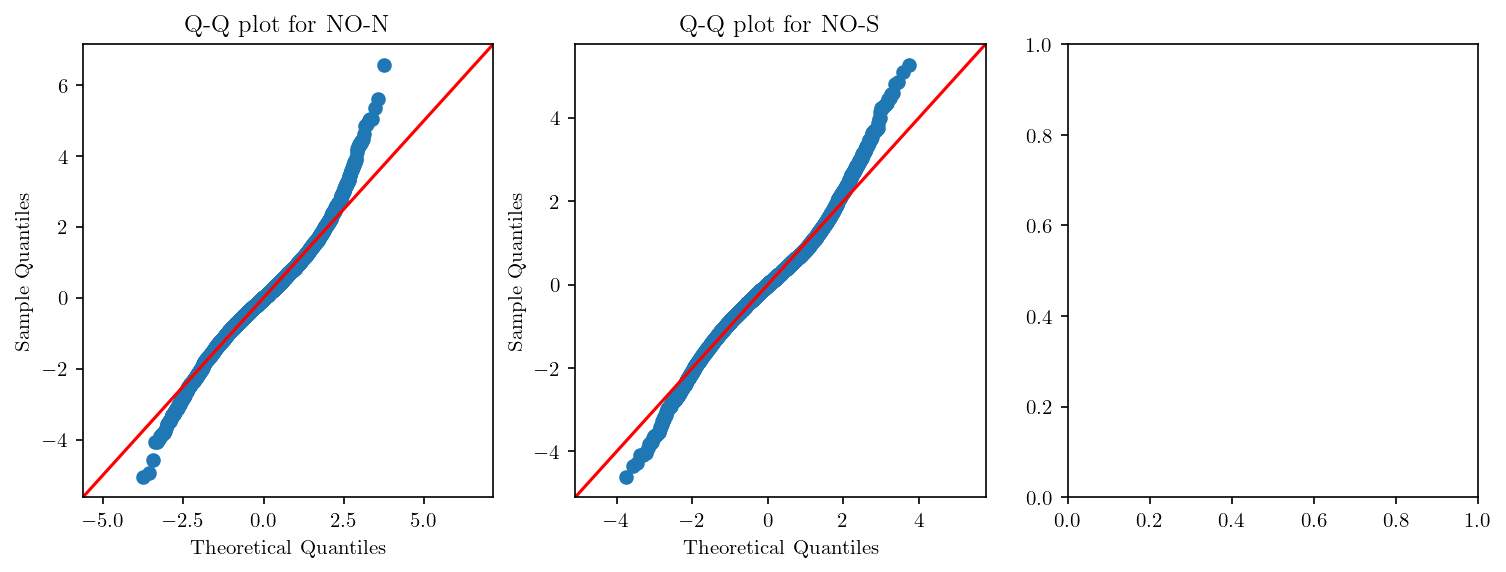

In [22]:
# We keep volatility constant, as this does not really improve the fit.
norm_anomaly = residual/residual.std()

fig, ax = plt.subplots(1,3, figsize = (12,4))
for i,c in enumerate(regions):
    sm.qqplot(norm_anomaly[c], line='45', ax = ax[i])
    ax[i].set_title(f"Q-Q plot for {c}")

In [23]:
# Generate data from AR model.
arma_process = {}
for c in regions:
    arma_process[c] = arma_generate_sample(ar = np.r_[1, -ar_params[c]], ma = np.array([1]), nsample=sample_length*365, scale = 1)
arma_process = pd.DataFrame.from_dict(arma_process)

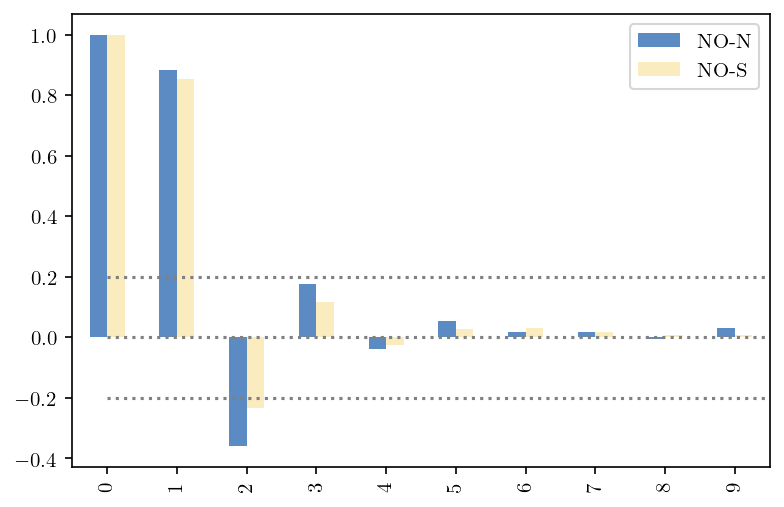

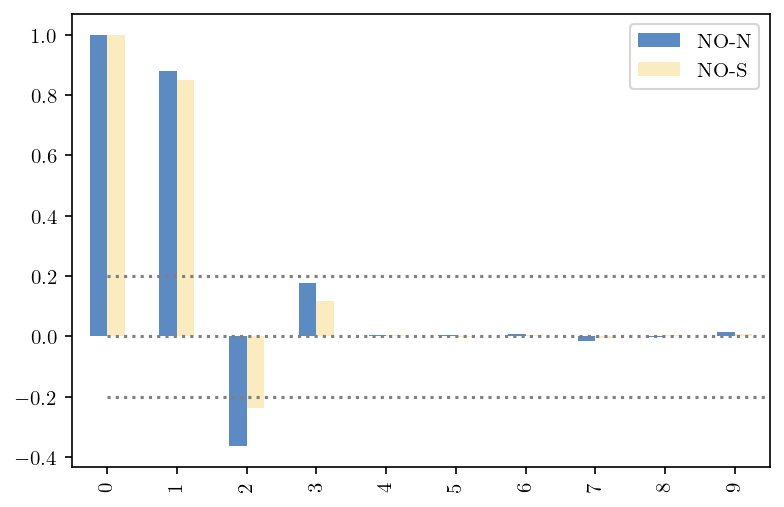

In [24]:
# Simulate without seasonal volatility

samples = {}
for c in regions:
    samples[c] = np.random.normal(0,1,size=sample_length*365)

sim_temperatures = pd.DataFrame(columns=regions)
for c in regions:
    sim_temperatures[c] = pd.concat(sample_length*[seasonality[c]], ignore_index=True) + arma_process[c] + samples[c] 

sim_deseasonalised = sim_temperatures - pd.concat(sample_length*[seasonality], ignore_index=True)

estimate_partialacf(deseasonalised)
estimate_partialacf(arma_process)

if save_files:
    seasonality.to_csv("data/processing/norway_seasonality_temp.csv")
    sim_temperatures.to_csv(f"data/processing/norway_regions_temperatures_{sample_length}y.csv")

## Synthesise demand data

In [25]:
# Initiate temperature data (generated from AR model) and demand.
regions = ["NO-N", "NO-S"]

daily_parameters = copy.deepcopy(par_hc_l) * 24 # these are originally hourly values

temp_parameters = temp_hc_l * 24 # these are hourly values

seasonal_temperatures = copy.deepcopy(seasonality)

temperatures_sample = copy.deepcopy(sim_temperatures)
cooling_sample = copy.deepcopy(sim_temperatures)
temperatures_sample = (15.5 - temperatures_sample).clip(0)
cooling_sample = (cooling_sample - 15.5).clip(0)

# original_demand = copy.deepcopy(demand)
# original_demand.index = pd.DatetimeIndex(original_demand.index)
# original_demand = original_demand.resample("1D").sum()
# original_demand = original_demand.reset_index()[regions]


In [26]:
# Prepare holidays for entire sample.
# Consider the years after 2001, we fill them up with holidays and they also start with a Monday (yay). However we will manually remove all the evil leap days.
years = list(range(2001, 2001 + sample_length))
list_holidays = {}
for c in regions:
    list_holidays[c] = holidays.CountryHoliday("NO", years = years)
    # Add last week of the year and Jan 2 as a holiday:
    for y in years:
        list_holidays[c].append(date(y,1,2))
        list_holidays[c].append(list(pd.date_range(start = date(y, 12, 24), end = date(y, 12, 31), freq = '1D')))

In [27]:
# Prepare data for each region.
demand_artificial = {}
for c in regions:
    demand_artificial[c] = pd.DataFrame(index = pd.date_range(start = date(2001,1,1), end = date(2000 + sample_length,12,31), freq = '1D'))
    demand_artificial[c]["weekday"] = demand_artificial[c].index.to_series().dt.dayofweek
    demand_artificial[c] = demand_artificial[c].loc[~demand_artificial[c].index.astype(str).str.contains('02-29')] 

for c, df in demand_artificial.items():
    for j in df.index:
        if j in list_holidays[c]:
            df.loc[j,"weekday"] = 6 # Set holidays to Sundays
        else:
            pass

In [28]:
# Generate demand process
for c,df in demand_artificial.items():
    for i in df.index:
        df.loc[i,c] = daily_parameters[c].loc[df["weekday"][i]]
    df = df.reset_index()[c]
    df += (temp_parameters["par_heating"] * temperatures_sample)[c] 
    df += (temp_parameters["par_cooling"] * cooling_sample)[c]
    demand_artificial[c] = df

demand_artificial = pd.DataFrame.from_dict(demand_artificial)
if save_files:
    demand_artificial.to_csv(f"data/processing/demand_norway_{sample_length}y.csv")

# Generate production data

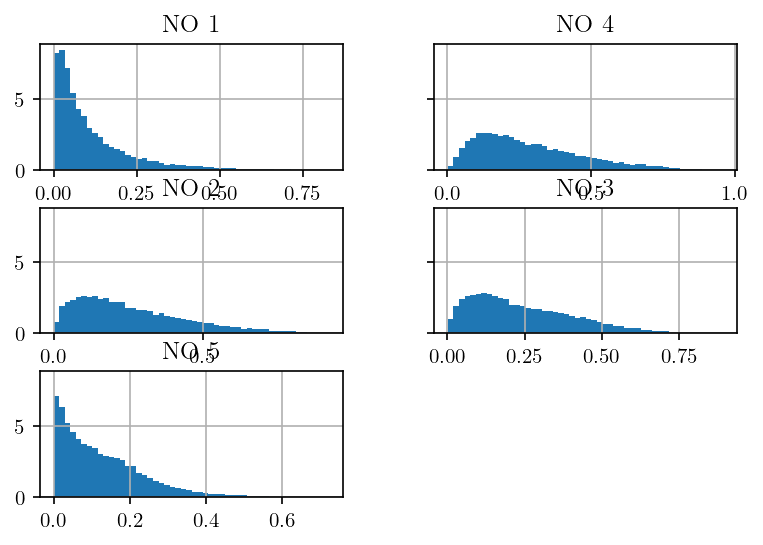

In [29]:
# # Load wind capacity factors from ERA5 for the market zones.
# years = range(1980,2020)


# cutouts = {}
# for y in years:
#     cutouts[y]= atlite.Cutout(path="../../research/modelling/new-cutouts/europe-era5_" + str(y) +".nc",
#     module="era5",
#     x = slice(4,32),
#     y=slice(57,72),
#     time=str(y)
#     )
#     cutouts[y].prepare()

norway = gpd.read_file('data/shapefiles/marketzones_4326.geojson')
norway = norway.set_index('ElSpotOmr')

# wind = {}
# for y in years:
#     wind[y] = cutouts[y].wind(shapes = norway, per_unit = True, turbine="Vestas_V112_3MW") 
# winds = xr.concat(wind.values(),dim='time')

# if save_files:
#     winds.to_pandas().to_csv("data/weather-input/ERA5_wind_norway-regions_1980-2020.csv")

winds = pd.read_csv("data/weather-input/ERA5_wind_norway-regions_1980-2020.csv", index_col = 0, infer_datetime_format=True)
winds.index = pd.DatetimeIndex(winds.index)
# winds = winds.to_pandas()
daily_wind = winds.resample('1D').mean()
daily_wind = daily_wind.loc[~daily_wind.index.astype(str).str.contains('02-29')]

# Daily wind histogram
daily_wind.hist(bins=50, density=True, sharey=True)

# Aggregate market zones to regions
south_area = sum(norway.loc[i, "Shape_Area"] for i in ["NO 1", "NO 2", "NO 5"])
north_area = sum(norway.loc[i, "Shape_Area"] for i in ["NO 3", "NO 4"])
south_shares = {}
north_shares = {}
for i in ["NO 1", "NO 2", "NO 5"]:
    south_shares[i] = round(norway.loc[i, "Shape_Area"]/south_area,3)
for i in ["NO 3", "NO 4"]:
    north_shares[i] = round(norway.loc[i, "Shape_Area"]/north_area,3)
daily_wind["NO-N"] = sum(daily_wind[i] * north_shares[i] for i in ["NO 3", "NO 4"])
daily_wind["NO-S"] = sum(daily_wind[i] * south_shares[i] for i in ["NO 1", "NO 2", "NO 5"])
daily_wind = daily_wind.round(4)
daily_wind.columns.name= "region"


In [30]:
# Checks and fixes for wind data.
regions = ["NO-N", "NO-S"]

# If the capacity factor equals 1, this leads to issues, so have a sanity check/fix as below.
# daily_wind[daily_wind==1.0000].dropna(how='all')
# daily_wind = daily_wind.where(daily_wind != 1.0000, 0.9999)

# Remove the dates, only have chronology.
C_orig = copy.deepcopy(daily_wind) 
C_orig = C_orig.reset_index()
C_orig = C_orig[regions]
C_orig = C_orig.astype(float)

<AxesSubplot:>

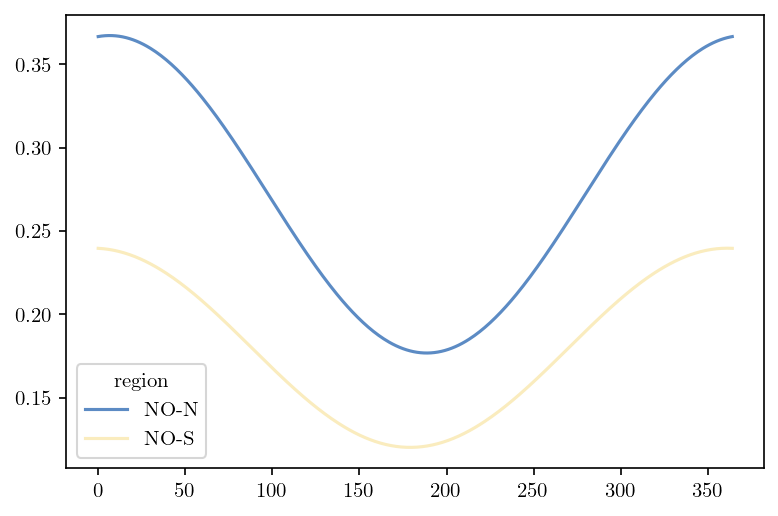

In [31]:
# Estimate seasonal capacity factors.
S_n, _ = seasonal_pattern(C_orig, plot = False)
S_n.plot(color = [cs["blue"], cs["yellow"]])

In [32]:
# Calculate X from C, our given capacity factors and the seasonality function.
X_orig = pd.DataFrame(columns=regions)

for i in range(len(daily_wind)):
    for c in regions:
        # coordinate-wise: X = - log (1 - C)/S
        X_orig.loc[i,c] = - (np.log(1 - C_orig.loc[i,c]))/S_n.loc[i % 365, c]
X_orig = X_orig.astype(float)

In [33]:
# Estimate Lambda. Compute the autocorrelation of X 
def acf(x,reg, length=365):
    return np.array([1]+[np.corrcoef(x[reg][:-i].values,x[reg][i:].values)[0,1] for i in range(1,length)])

autocorr = {}
for reg in regions:
    autocorr[reg] = acf(X_orig,reg)

# Lag computations
# Compute (lambda^hat)_i
def compute_lambda(x, length=25):
    Lambda = {}
    for key in x.keys():
        e_acf = statsmodels.tsa.stattools.acf(x[key],nlags=length)
        def acf_minimizer(z):
            value = 0
            for i in range(1,length+1):
                value += (e_acf[i] - np.exp(-z * i))**2
            return value
        Lambda[key] = sp.optimize.minimize_scalar(acf_minimizer).x
    return Lambda

# Estimate the lag (of length 1)
Lambda = compute_lambda(X_orig)
print(Lambda)

# Diagonal matrix consisting of the lags.
Lambda_hat = np.diag(list(Lambda.values()))

{'NO-N': 0.520206506674971, 'NO-S': 0.6735811818036888}


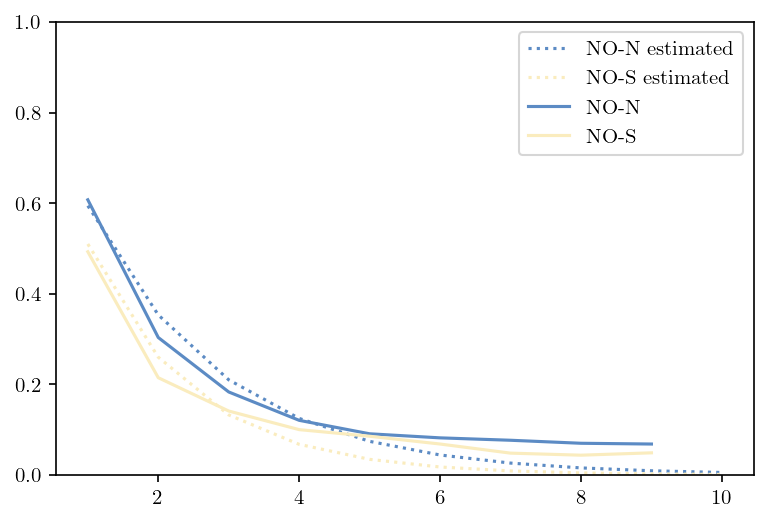

In [34]:
# Modelled ACF vs estimated ACF
fig, ax = plt.subplots()
for key, color in zip(Lambda.keys(), [cs["blue"], cs["yellow"]]):
    ax.plot(np.linspace(1,10,10), [np.exp(-Lambda[key]*j) for j in np.linspace(1,10,10)], ls = ":", label=key + " estimated", color = color)
ax.set_ylim(0,1)
#Compare to empirical ACF
pd.DataFrame.from_dict(autocorr)[1:10].plot(ax=ax, color = [cs["blue"], cs["yellow"]], label = "empirical")
ax.legend();

In [35]:
# Covariance and correlation 
# Estimate the empirical covariance.
Sigma_X = np.cov(X_orig.T.values)

# Correlation
np.corrcoef(X_orig.T.values)


array([[1.        , 0.37069819],
       [0.37069819, 1.        ]])

In [36]:
# Estimate idiosyncratic risks (Sigma) for jumps.
# Lambda_tilde which has values (lambda_i + lambda_j)_{i,j}
Lambda_var = np.zeros((len(regions), len(regions)),dtype=float)
for i,val1 in enumerate(list(Lambda.values())):
    for j,val2 in enumerate(list(Lambda.values())):
        Lambda_var[i,j] = (val1 + val2)

# Get Sigma_L for jump process
def Sigma_L_minimiser(y: np.array):
    z = np.reshape(y, (len(regions), len(regions))) # want a quadratic array
    return np.linalg.norm((np.matmul(z,z.T)- np.multiply(Lambda_var, Sigma_X)))**2 # as in overleaf (different, equivalent formulation in BCR)

# needs to use an 1D array, so would need to flatten matrices, but we can just use the reshape function at the end.
def find_Sigmahat_L():   
    constraints = []
    # for i in range(len(regions)):
    #     # this ensures that the sigma values are nonnegative
    #     constraint_matrix = np.zeros((len(regions), len(regions)))
    #     constraint_matrix[i,i] = 1
    #     cs = sp.optimize.LinearConstraint(A = constraint_matrix, lb = 0, ub = np.inf)
    #     constraints.append(cs)
    dims = 2 * len(regions)
    for i in range(dims):
        # this ensures that the sigma values are nonnegative
        constraint_matrix = np.zeros((dims, dims))
        constraint_matrix[i,i] = 1
        cs = sp.optimize.LinearConstraint(A = constraint_matrix, lb=0, ub = np.inf)
        constraints.append(cs)
    result = sp.optimize.minimize(Sigma_L_minimiser, x0 =np.ones(dims), constraints = constraints, method="trust-constr")
    matr = result.x
    # result = sp.optimize.minimize(Sigma_L_minimiser, x0= np.ones(len(regions)), constraints=constraints)
    return np.reshape(matr, (len(regions), len(regions)))

Sigmahat_L = find_Sigmahat_L()

sigma_diag = pd.Series([Sigmahat_L[0,0], Sigmahat_L[1,1]], index=regions)

In [37]:
# Estimate stationary distribution
gamma_fits = {}
for c in X_orig.columns:
    a,b,d = gamma.fit(X_orig[c],floc=0)
    gamma_fits[c] = (a,d)
Gammafits = pd.DataFrame.from_dict(gamma_fits).T
Gammafits.columns = ['a', 'b'] # corresponding to a and scale in scipy.gamma

# The stationary distribution, assuming it follows the model as in the jump process should be gamma with parameters alpha/lambda, beta/sigma, now that the common factor is removed. Having estimated lamma, sigma (coming from sigmahat, not sigma!) we can calculate these values by multiplying with lambda and sigma resp.

# Estimate the intensity of the jumps
gamma_alpha = Gammafits['a'] * pd.DataFrame.from_dict(Lambda, orient='index', columns=['lag'])['lag']
gamma_beta = Gammafits['b'] * sigma_diag


In [38]:
# Following BCR, we can estimate alpha and beta also differently.


# Invert Lambda.
Lambda_inv = np.diag(list([1/value for value in list(Lambda.values())]))
Lambda_inv

# mean of X_orig
mu_X_orig = X_orig.mean()

def gurobi_beta(regions,mu_X, Sigmahat_L, Lambda_inv):
    """Approximates beta as follows:
     min_beta|| mu_x - (Lambda)^(-1) \Sigmahat_L beta/2 ||^2
    """
    m = gp.Model()
    dims = len(regions) 
    lb = [[1e-5] * dims] # Ensure positive values of y = beta
    y = m.addMVar(dims,lb=lb)
    m.Params.OutputFlag = 0
    # Define auxiliary variables
    LamSig = m.addMVar((dims, dims))
    LSY = m.addMVar(dims)
    mL = m.addMVar(dims)
    # In order to use the norm and square, need to do some Gurobi hacking. E.g. np.matmul does not work as easily here (why?), so do it coordinatewise
    # Lambda_inv * Sigmahat_L
    m.addConstrs((LamSig[i,j] == Lambda_inv[i,:] @ Sigmahat_L[:,j] for i in range(dims) for j in range(dims)))
    # (Lambda_inv * Sigmahat_L) * beta
    m.addConstrs((LSY[i] == sum(LamSig[i,j] * y[j] for j in range(dims)) for i in range(dims)))
    # mu_X - (Lambda_inv * Sigmahat_L) * beta/2
    m.addConstrs(mL[i] == mu_X[i] - LSY[i] * (1/2) for i in range(dims))
    m.setObjective(sum((mL[i]**2 for i in range(dims))), GRB.MINIMIZE)
    m.optimize()
    return y.X


betahat = gurobi_beta(regions, mu_X_orig, Sigmahat_L, Lambda_inv)
betahat = pd.DataFrame(betahat)
betahat.index = regions

alphahat = (betahat)**2/2
alphahat = pd.DataFrame(alphahat)
alphahat.index = regions

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-08


## Simulation

In [39]:
steps= 365 * sample_length + 1 # Simulate 100 artificial years.

sigmahat_L = pd.DataFrame(Sigmahat_L, index=regions, columns=regions)

exp_Lambda = sp.linalg.expm(-Lambda_hat)

In [40]:
def simulate_jump_process(poisson_par, expon_par, steps = steps, regions = regions, exp_Lambda = exp_Lambda, sigmahat_L = Sigmahat_L):
    jump_dict = dict.fromkeys(regions)
    for reg in regions:
        # Since we expect `poisson_par` jumps in one time period, we simulate poisson_par*steps*1.5 jump times.
        jump_diffs = []
        T = 0
        while T < steps:
            jump_time = T + expon.rvs(scale=1/poisson_par[reg])
            T = jump_time
            if jump_time < steps:
                jump_diffs.append(jump_time)
        jump_dict[reg] = jump_diffs   
    # Reorder the jumps
    df = pd.concat([pd.DataFrame(values) for values in list(jump_dict.values())],ignore_index=True)
    df.columns = ["jump_time"]
    df = df.sort_values("jump_time")
    for i in range(len(df)):
        for c in regions:
            df.loc[i,c] = 1 if df.loc[i, "jump_time"] in jump_dict[c] else 0
    df.reindex()
    df = df.set_index("jump_time")
    # Have all the jumps separated by reg.
    jump_time_dict = {}
    for c in df.columns:
        jump_time_dict[c] = df[c][df[c] ==1]
    # Draw the jump sizes
    jumps = {}
    for reg in regions:
        jumps[reg] = pd.DataFrame(expon.rvs(scale=1/expon_par[reg], size=len(jump_time_dict[reg])),index= jump_time_dict[reg].index, columns=[reg])
    # Keep all the jumps in one dataframe for easing the later calculations
    all_jumps = pd.DataFrame()
    all_jumps = pd.concat(jumps.values(),axis=1).fillna(0.)
    all_jumps = all_jumps.sort_index()
    # Compute the Levy increments
    Levy_steps = []
    jump_iterator = iter(all_jumps.index)
    cached_jump_time = next(jump_iterator)
    for i in range(steps):
        lstep = np.zeros(len(regions))
        while cached_jump_time >= i and cached_jump_time < i+1:
            try:
                lstep += exp_Lambda**(i+1 - cached_jump_time) @ sigmahat_L.values @ all_jumps.loc[cached_jump_time]
                cached_jump_time = next(jump_iterator)
            except StopIteration:
                print("Computed all Levy steps")
                break
        Levy_steps.append(lstep)
    # Simulate the process.
    random_start = np.random.randint(0, len(X_orig),size=1)[0]
    initial_value = X_orig.loc[random_start]
    X = pd.DataFrame(initial_value).T
    X = X.reset_index()[regions]
    X.columns = regions
    C = pd.DataFrame(columns=regions)
    for i in range(1,steps):
        X.loc[i] = exp_Lambda @ X.loc[i-1] + Levy_steps[i]
        C.loc[i] = 1 - np.exp(- S_n.loc[(i)% 365] * X.loc[i])
    return X,C

In [41]:
Y, D = simulate_jump_process(alphahat.T, betahat.T, steps, regions, exp_Lambda, sigmahat_L)
if save_files:
    D.to_csv(f"data/processing/norway_regions_production_corr_{sample_length}y.csv")

Computed all Levy steps


In [42]:
D = D.reset_index()[regions]
D

,NO-N,NO-S
0,0.255889,0.111397
1,0.161174,0.058423
2,0.141996,0.099348
3,0.097390,0.211111
4,0.059096,0.113825
...,...,...
36495,0.290044,0.159932
36496,0.637033,0.277276
36497,0.533931,0.188142
36498,0.365689,0.117158


<AxesSubplot:>

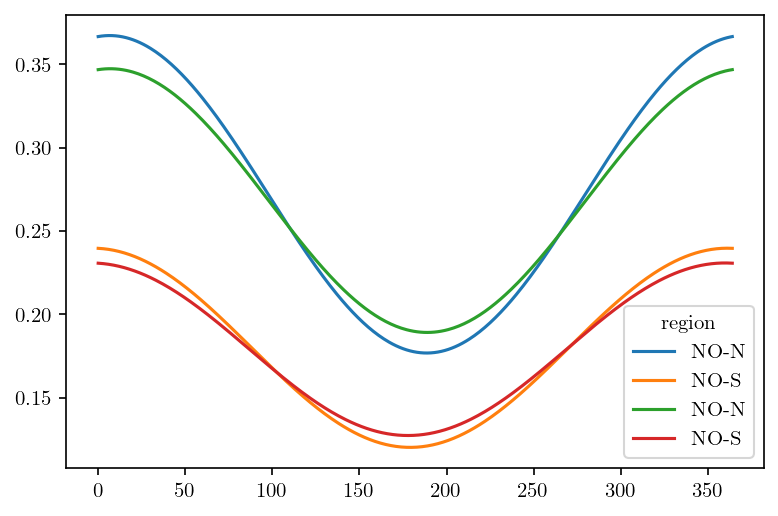

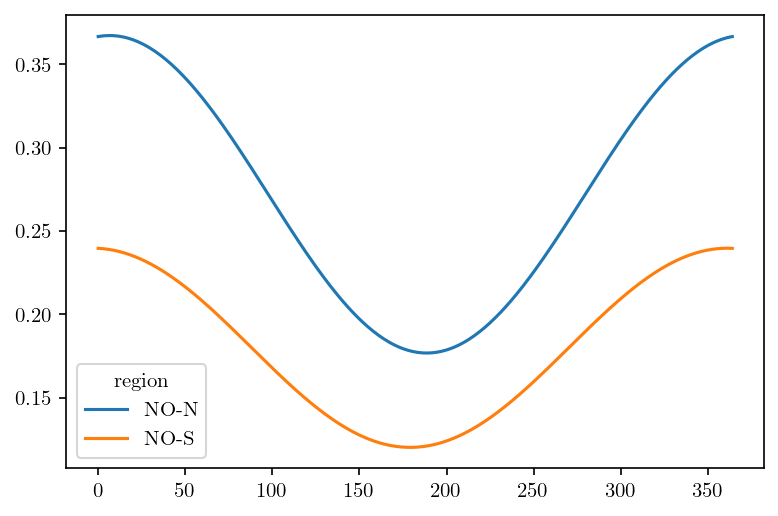

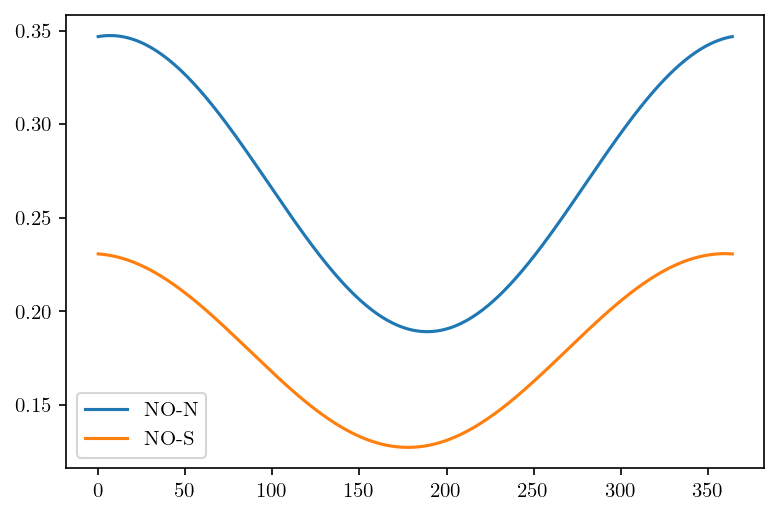

In [43]:
fig, ax = plt.subplots()
seas_orig, _ = seasonal_pattern(C_orig, 365);
seas_sim, _ = seasonal_pattern(D, 365);
seas_orig.plot(ax=ax, label="Original")
seas_sim.plot(ax=ax, label="Simulated")

## Validation

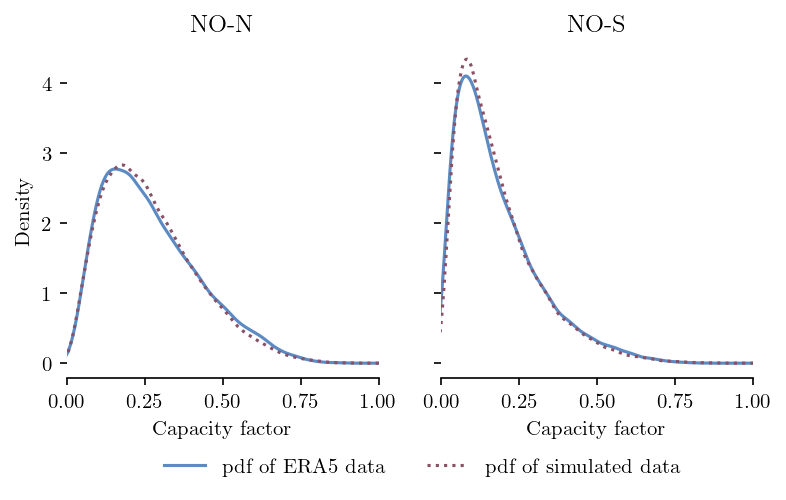

In [44]:
# Plot density of the original C a nd estimated C's
fig, ax = plt.subplots(1,2, figsize = (15*cm,7.5*cm), sharex=True, sharey=True)

# ax[0].plot.density(C_orig)
for (i, loc) in enumerate(["NO-N", "NO-S"]):
    ax[i].set_title(f"{loc}")
    ax[i].set_xlim(0,1);
    ax[i].set_xlabel("Capacity factor")
    C_orig[loc].plot.density(ax=ax[i], label = "pdf of ERA5 data", color = cs["blue"]);
    #ax[1].plot.density(D)
    D[loc].plot.density(ax=ax[i], ls="dotted", label = "pdf of simulated data", color = cs["burgundy"]);
ax[0].legend(bbox_to_anchor = (0.25, -0.35), loc="lower left", ncol=2, frameon=False)

for axis in ax:
    axis.spines["right"].set_visible(False)
    axis.spines["top"].set_visible(False)
    axis.spines["left"].set_visible(False)
fig.savefig("./figures/paper_plots/cap_factors.pdf", bbox_inches='tight')


In [45]:
est_means = pd.DataFrame([C_orig.mean(), D.mean()
#, E.mean()
], index = ['original', 'BCR', 
#'BCR/Gamma'
])
est_sd = pd.DataFrame([C_orig.std(), D.std()], index = ['original', 'BCR',])
est_skewed = pd.DataFrame([C_orig.skew(), D.skew()], index = ['original', 'BCR', ])
est_kurtosis = pd.DataFrame([C_orig.kurtosis(), D.kurtosis()], index = ['original', 'BCR'])
print("First moment")
display(est_means)
print("Second moment")
display(est_sd)
print("Third moment")
display(est_skewed)
print("Fourth moment")
display(est_kurtosis)
print("Correlation of capacity factors")
display(C_orig.corr())
display(D.corr())
print("Correlation of processes")
display(X_orig.corr())
display(Y.corr())

First moment


,NO-N,NO-S
original,0.272261,0.180063
BCR,0.268438,0.179174


Second moment


,NO-N,NO-S
original,0.155196,0.134532
BCR,0.150275,0.130592


Third moment


,NO-N,NO-S
original,0.752868,1.25116
BCR,0.767171,1.33524


Fourth moment


,NO-N,NO-S
original,0.044044,1.476216
BCR,0.255631,1.972546


Correlation of capacity factors


region,NO-N,NO-S
region,,
NO-N,1.000000,0.463823
NO-S,0.463823,1.000000


,NO-N,NO-S
NO-N,1.000000,0.470735
NO-S,0.470735,1.000000


Correlation of processes


,NO-N,NO-S
NO-N,1.000000,0.370698
NO-S,0.370698,1.000000


,NO-N,NO-S
NO-N,1.000000,0.366319
NO-S,0.366319,1.000000


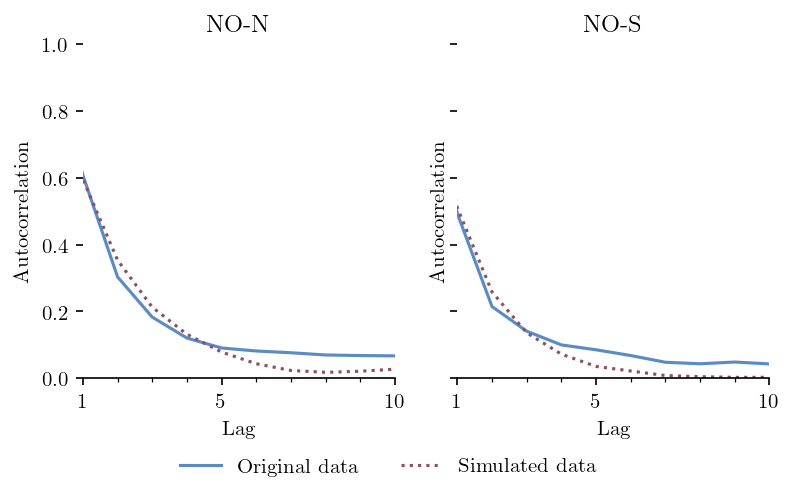

In [54]:
# Compare autocorrelation
fig, ax = plt.subplots(1,2, figsize = (15*cm,7.5*cm), sharex=True, sharey=True)
for i, loc in enumerate(["NO-N", "NO-S"]):
    ax[i].set_title(f"{loc}")
    ax[i].set_xlim(1,10);
    ax[i].set_xlabel("Lag")
    ax[i].set_ylabel("Autocorrelation")
    ax[i].plot(autocorr[loc], label="Original data", color = cs["blue"])
    ax[i].plot(statsmodels.tsa.stattools.acf(Y[loc],nlags=365), ls="dotted", label="Simulated data", color = cs["burgundy"])
    ax[i].set_ylim(0,1)
    for spine in ["top", "left", "right"]:
        ax[i].spines[spine].set_visible(False)
    ax[i].xaxis.set_major_locator(FixedLocator([1, 5, 10]))
    ax[i].xaxis.set_major_formatter(FixedFormatter([1, 5, 10]))
    ax[i].xaxis.set_minor_locator(FixedLocator([2,3,4,6,7,8,9]))
    ax[0].legend(bbox_to_anchor = (0.25, -0.35), loc="lower left", ncol=2, frameon=False)
fig.savefig("./figures/paper_plots/autocorrelation.pdf", bbox_inches='tight')

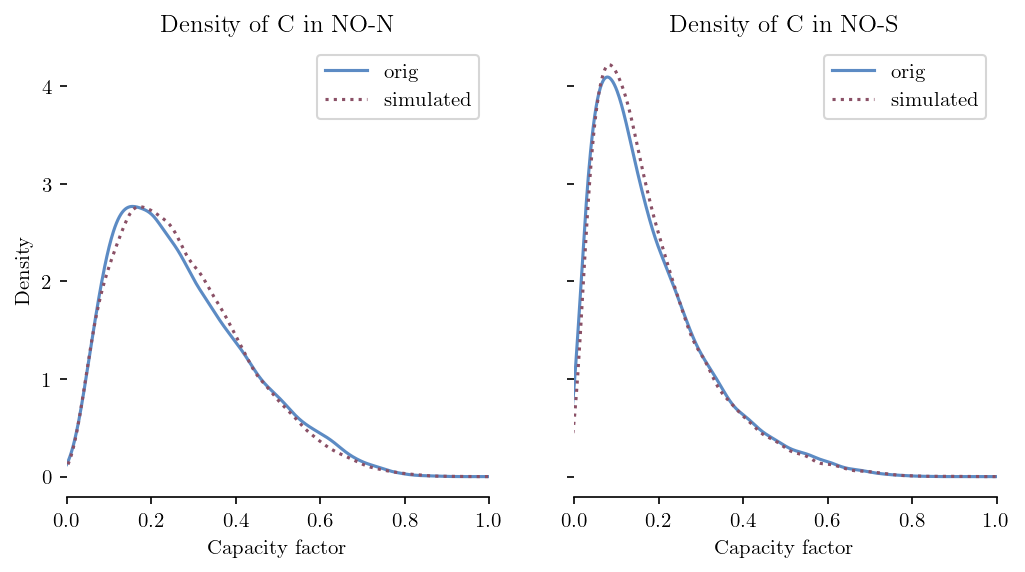

In [49]:
fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
for i, reg in enumerate(["NO-N", "NO-S"]):
    ax[i].set_xlim(0,1)
    ax[i].set_title(f"Density of C in {reg}")
    C_orig[reg].plot.density(ax=ax[i], label = "orig", color = cs["blue"] )
    D[reg].plot.density(ax=ax[i], label = "simulated", ls="dotted", color = cs["burgundy"])
    ax[i].legend()
    ax[i].set_xlabel("Capacity factor")

for axis in ax.flatten():
    for loc in ["top", "left", "right"]:
        axis.spines[loc].set_visible(False)

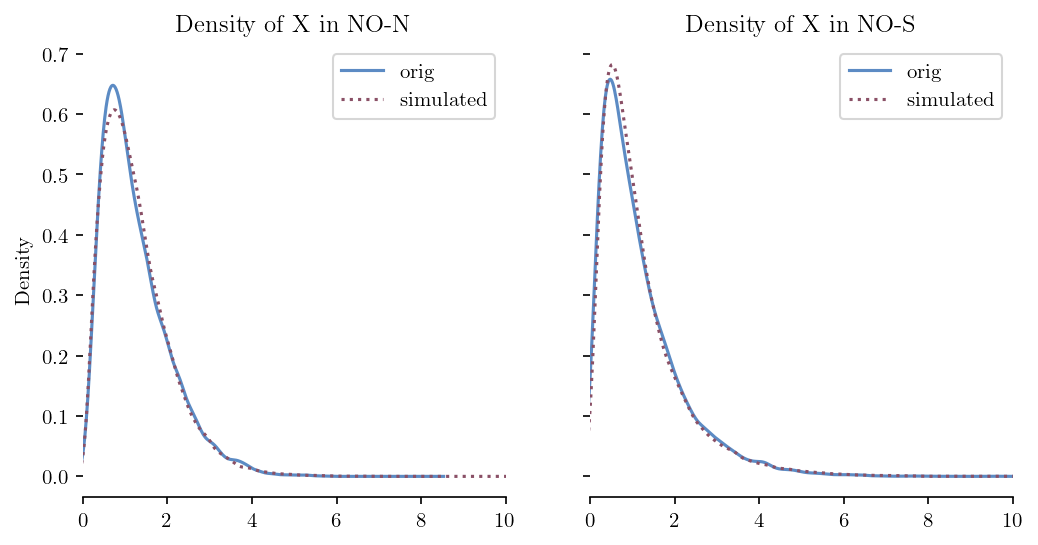

In [50]:
fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
for i, reg in enumerate(["NO-N", "NO-S"]):
    ax[i].set_xlim(0,10)
    ax[i].set_title(f"Density of X in {reg}")
    X_orig[reg].plot.density(ax=ax[i], label = "orig", color = cs["blue"] )
    Y[reg].plot.density(ax=ax[i], label = "simulated", ls="dotted", color = cs["burgundy"])
    ax[i].legend()

for axis in ax.flatten():
    for loc in ["top", "left", "right"]:
        axis.spines[loc].set_visible(False)